# The features and shortcomings of Bayesian Networks (with CausalNex)

Bayesian Networks and structural causal models are really exciting. These methods invite us to *think hard* about our business problem and our assumptions. Causal graphs make it easy for everyone (not just data scientists) reason about and criticize the model. This level of explainability and rigor are in a stark contrast with the black box fit / predict logic that is very much present in the data science industry.

However, the widespread adoption of these models in industry still has yet to happen, at least from my personal standpoint. Given the growing interest of the community and new tools backed by big industry names (such as [CausalNex](https://causalnex.readthedocs.io/en/latest/) by McKinsey / QuantumBlack), I thought it would be cool to try them out and check out features and shortcomings from an industry practitioner standpoint.

So, in this post, I'll report my first try working with Bayesian Networks, more specifically using the CausalNex library. We'll try to solve a [synthetic causal inference problem](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html) from Nubank's fklearn library (the same that I've already used in several other [posts](https://gdmarmerola.github.io/diagnosting-validity-causal-effects-trees/)). Having a synthetic dataset gives us the benefit of knowing the true treatment effect and counterfactuals, providing objective evidence on the performance of the algorithm, even if it does not carry the weight of a thorough benchmark. 

Throughout the post, I'll try to point out the **features** and **shortcomings** of our Bayesian Networks / Causal Nex approach. Without further ado, let's dive in!

##### *General imports*

In [1]:
# changing working directory
import sys
sys.path.append("../")
%matplotlib inline

# better plots
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# suppress annoying causal nex warnings
import warnings
warnings.filterwarnings("ignore")

##### *For converting tables to markdown*

In [2]:
def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

##### *For plotting structural models*

In [3]:
import networkx as nx

def plot_structure(g):
    
    color_mapping = {
        'sex': 'black',
        'age': 'black',
        'severity': 'black',
        'medication': 'royalblue',
        'recovery': 'firebrick'
    }
    
    fig = plt.figure(figsize=(18, 10)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    
    pos = {
        'age': [0.20,0.60],
        'severity': [0.30,0.60],
        'sex': [0.40,0.60],
        'medication': [0.45, 0.45],
        'recovery': [0.35, 0.30],
    }

    # add nodes to figure
    nx.draw_networkx_nodes(
        g,
        pos,
        node_shape='8',
        node_size=8000,
        linewidths=3,
        edgecolors="black",
        node_color=[color_mapping[e] for e in g.nodes],
    )
    
    nx.draw_networkx_labels(
        g,
        pos,
        font_color="white",
        font_weight="bold",
        font_family="Monospace",
        font_size=12,
    )
    
    nx.draw_networkx_edges(
        g,
        pos,
        edge_color="black",
        style='dashed',
        arrowsize=30,
        node_size=8000
    )

##### *`make_confounded_data` function*

In [4]:
import numpy as np
from numpy import nan
import pandas as pd

# REPRODUCING make_confounded_data FUNCTION FROM
# FKLEARN FOR SYMPLICITY, AS FKLEARN HAS STRICT REQUIREMENTS
# FOR SKLEARN, PANDAS AND NUMPY AND WE WANTED TO DECOUPLE FROM IT
# WE'RE NOT CREDIBLE FOR THIS CODE
# LINK: https://github.com/nubank/fklearn/blob/master/src/fklearn/data/datasets.py

def make_confounded_data(n):
    """
    Generates fake data for counterfactual experimentation. The covariants are
    sex, age and severity, the treatment is a binary variable, medication and the response
    days until recovery.
    Parameters
    ----------
    n : int
        The number of samples to generate
    Returns
    ----------
    df_rnd : pd.DataFrame
        A dataframe where the treatment is randomly assigned.
    df_obs : pd.DataFrame
        A dataframe with confounding.
    df_df : pd.DataFrame
        A counter factual dataframe with confounding. Same as df_obs, but
        with the treatment flipped.
    """

    def get_severity(df):
        return ((np.random.beta(1, 3, size=df.shape[0]) * (df["age"] < 30))
                + (np.random.beta(3, 1.5, size=df.shape[0]) * (df["age"] >= 30)))

    def get_treatment(df):
        return (.33 * df["sex"]
                + 1.5 * df["severity"]
                + 0.15 * np.random.normal(size=df.shape[0]) > 0.8).astype(float)

    def get_recovery(df):
        return np.random.poisson(np.exp(2
                                        + 0.5 * df["sex"]
                                        + 0.03 * df["age"]
                                        + df["severity"]
                                        - df["medication"]))

    np.random.seed(1111)
    sexes = np.random.randint(0, 2, size=n)
    ages = np.random.gamma(8, scale=4, size=n)
    meds = np.random.randint(0, 2, size=n)

    # random data
    df_rnd = pd.DataFrame(dict(sex=sexes, age=ages, medication=meds))
    df_rnd['severity'] = get_severity(df_rnd)
    df_rnd['recovery'] = get_recovery(df_rnd)

    features = ['sex', 'age', 'severity', 'medication', 'recovery']
    df_rnd = df_rnd[features]  # to enforce column order

    # obs data
    df_obs = df_rnd.copy()
    df_obs['medication'] = get_treatment(df_obs)
    df_obs['recovery'] = get_recovery(df_obs)

    # counter_factual data
    df_ctf = df_obs.copy()
    df_ctf['medication'] = ((df_ctf['medication'] == 1) ^ 1).astype(float)
    df_ctf['recovery'] = get_recovery(df_ctf)

    return df_rnd, df_obs, df_ctf

## Data: `make_confounded_data` from `fklearn`

Nubank's `fklearn` module provides a nice synthetic causal inference problem generator, so we're going to use the same data generating process and example from its [documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html). 

In [5]:
# generating 
df_rnd, df_obs, df_cf = make_confounded_data(50000)
df_obs.head(5)

,sex,age,severity,medication,recovery
0,0,16.354103,0.047350,0.0,14
1,1,24.182983,0.099184,0.0,27
2,1,25.483159,0.349073,1.0,14
3,1,52.195765,0.536694,1.0,26
4,0,48.816918,0.631806,1.0,28


We have five features: `sex`, `age`, `severity`, `medication` and `recovery`. We want to estimate the impact of `medication` on `recovery`. So, our *target* variable is `recovery`, our *treatment* variable is `medication` and the rest are our *explanatory* variables.

A good counterfactual model will tell us how would be the recovery time for each individual for both potential decisions of taking or not taking medication. The model should be robust to confounders, variables that affect the probability of someone taking the medication. For instance, people with higher `severity` may be more likely to take the medicine. If not properly taken into account, this confounder may lead us to conclude that the medication may make recovery worse: people that took the medication may have recovered more slowly (effectively ignoring that their condition was also more severe in the first place). In the [fklearn's documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html), the data generating process is shown in detail, highlighting the confounders in the data. The effect we're looking for is 

$$\frac{E[recovery \vert medication = 1]}{E[recovery \vert medication = 0]} = exp(-1) = 0.368$$.

The `make_confounded_data` function outputs three data frames: `df_rnd`, where treatment assingment is random, `df_obs`, where treatment assingment is confounded and `df_cf`, which is the counterfactual dataframe, containing the counterfactual outcome for all the individuals.

## 1. Structure

We can divide our causal inference problem in two steps:

1. Define (or learn) the *structure* of the problem. The structure determines which variables are causes of others and is represented by a causal diagram: a directed acyclic graph representing these relationships
2. Given a structure and data, compute the counterfactual (treatment effect) of taking the medication vs. not taking it.

Let us start with step (1).

### True (Oracle) Structure

As we're dealing with a simulated dataset, we have the luxury if knowing the true structure of the problem. It is very easy to define this through the CausalNex `StructureModel` API:

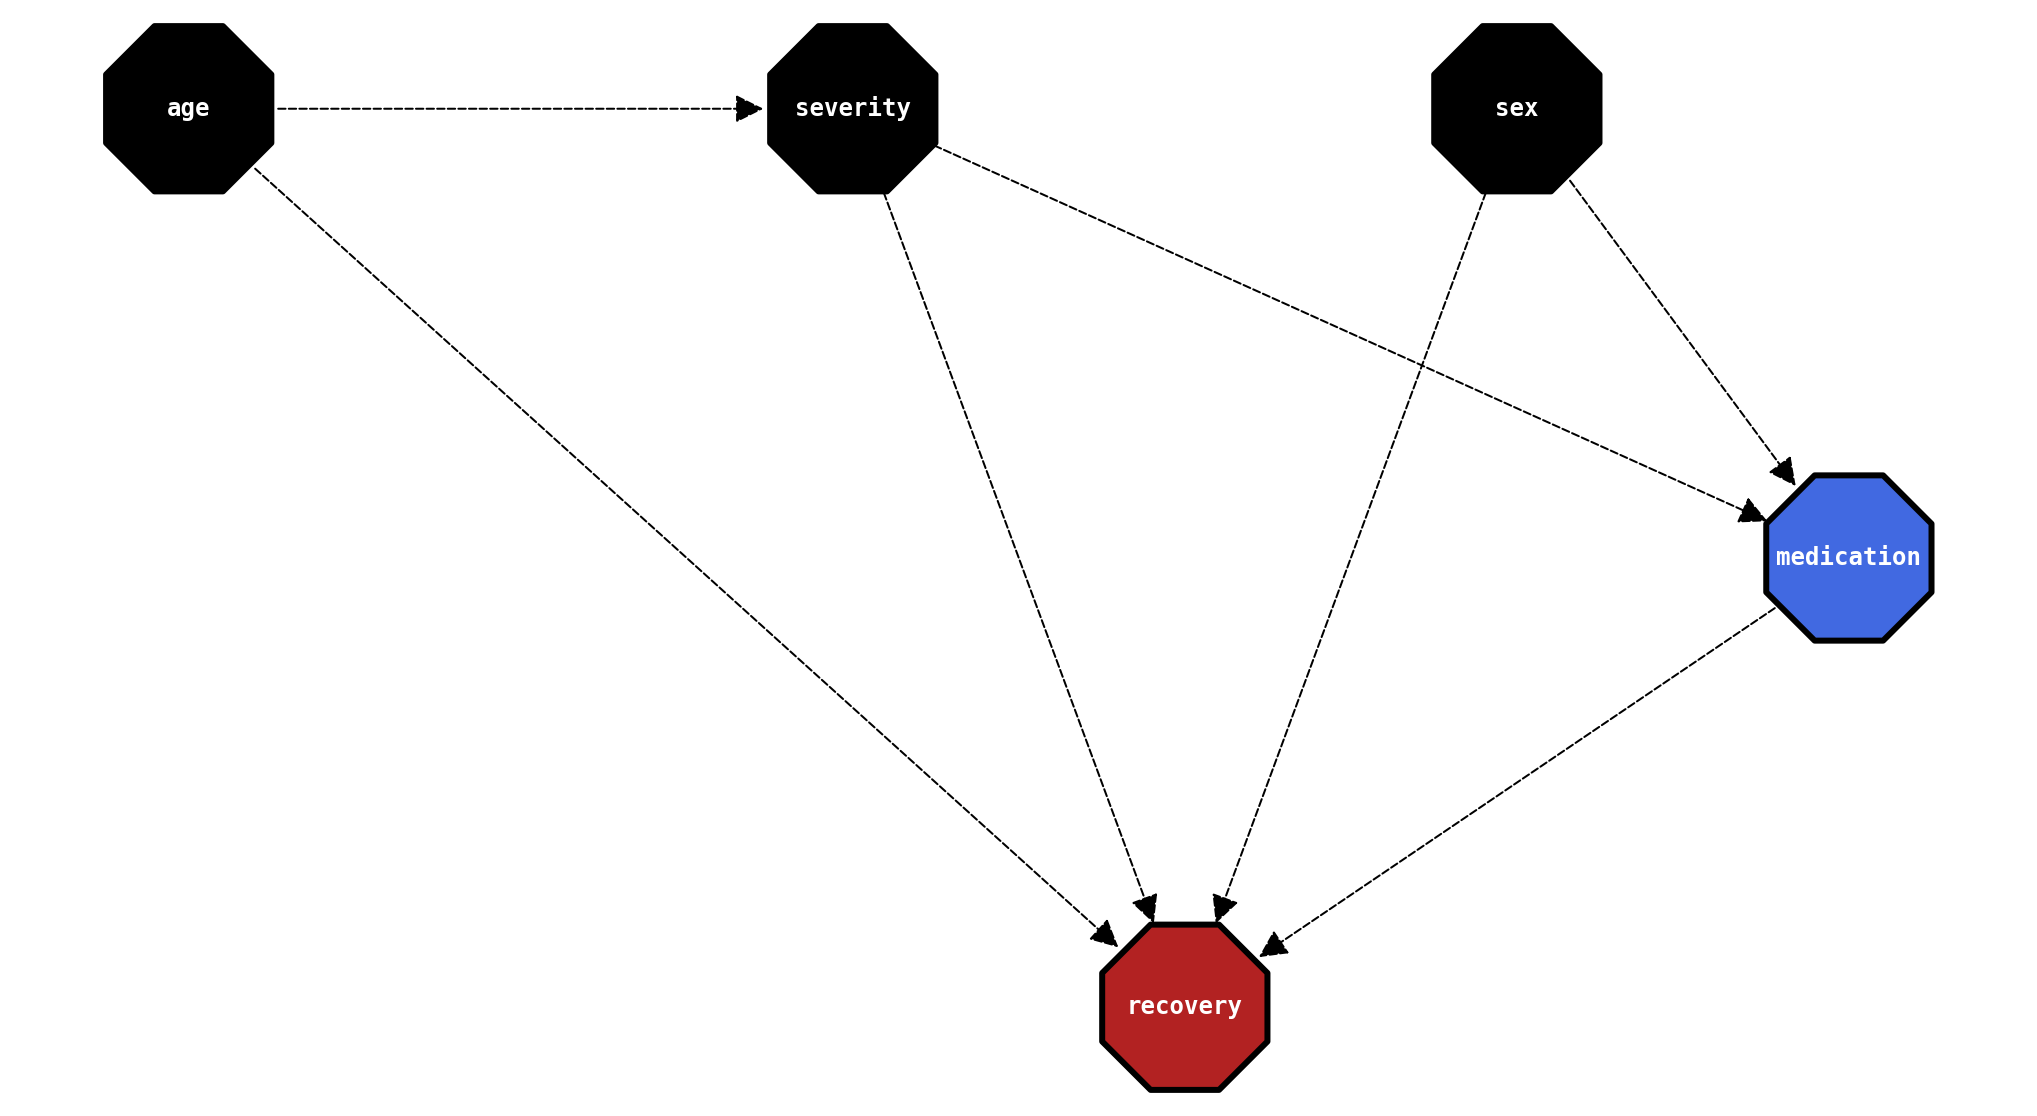

In [7]:
from causalnex.structure import StructureModel
sm_true = StructureModel()

sm_true.add_edges_from([
    ('age', 'severity'),
    ('sex', 'medication'),
    ('severity', 'medication'),
    ('medication', 'recovery'),
    ('sex', 'recovery'),
    ('age', 'recovery'),
    ('severity', 'recovery'),
])

plot_structure(sm_true)

If you're still confused about structural causal models now things may get clearer. The arrow sets the direction of causality, such that `a -> b` means that `a` *causes* `b`. So in our case `recovery` (our target, in red) is caused by all variables. The treatment variable, `medication`, is caused by `sex` and `severity`, and `severity` is caused by `age`. 

Remeber that this is a simulated dataset. We know the true diagram because we created it and defined that data generating process (in detail [here](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html)). In an industry application, we would never be sure of the diagram and would count on domain experts to try to make it reproduce reality as much as we can.

In any case, having the possibility of reasoning about the structure of the problem is clearly a **feature** to the practitioner!

### Trying to learn structure from data

CausalNex provides the ability to infer the structure from data, through the NOTEARS algorithm. The algorithm receives our data and a threshold to remove weak edges. 

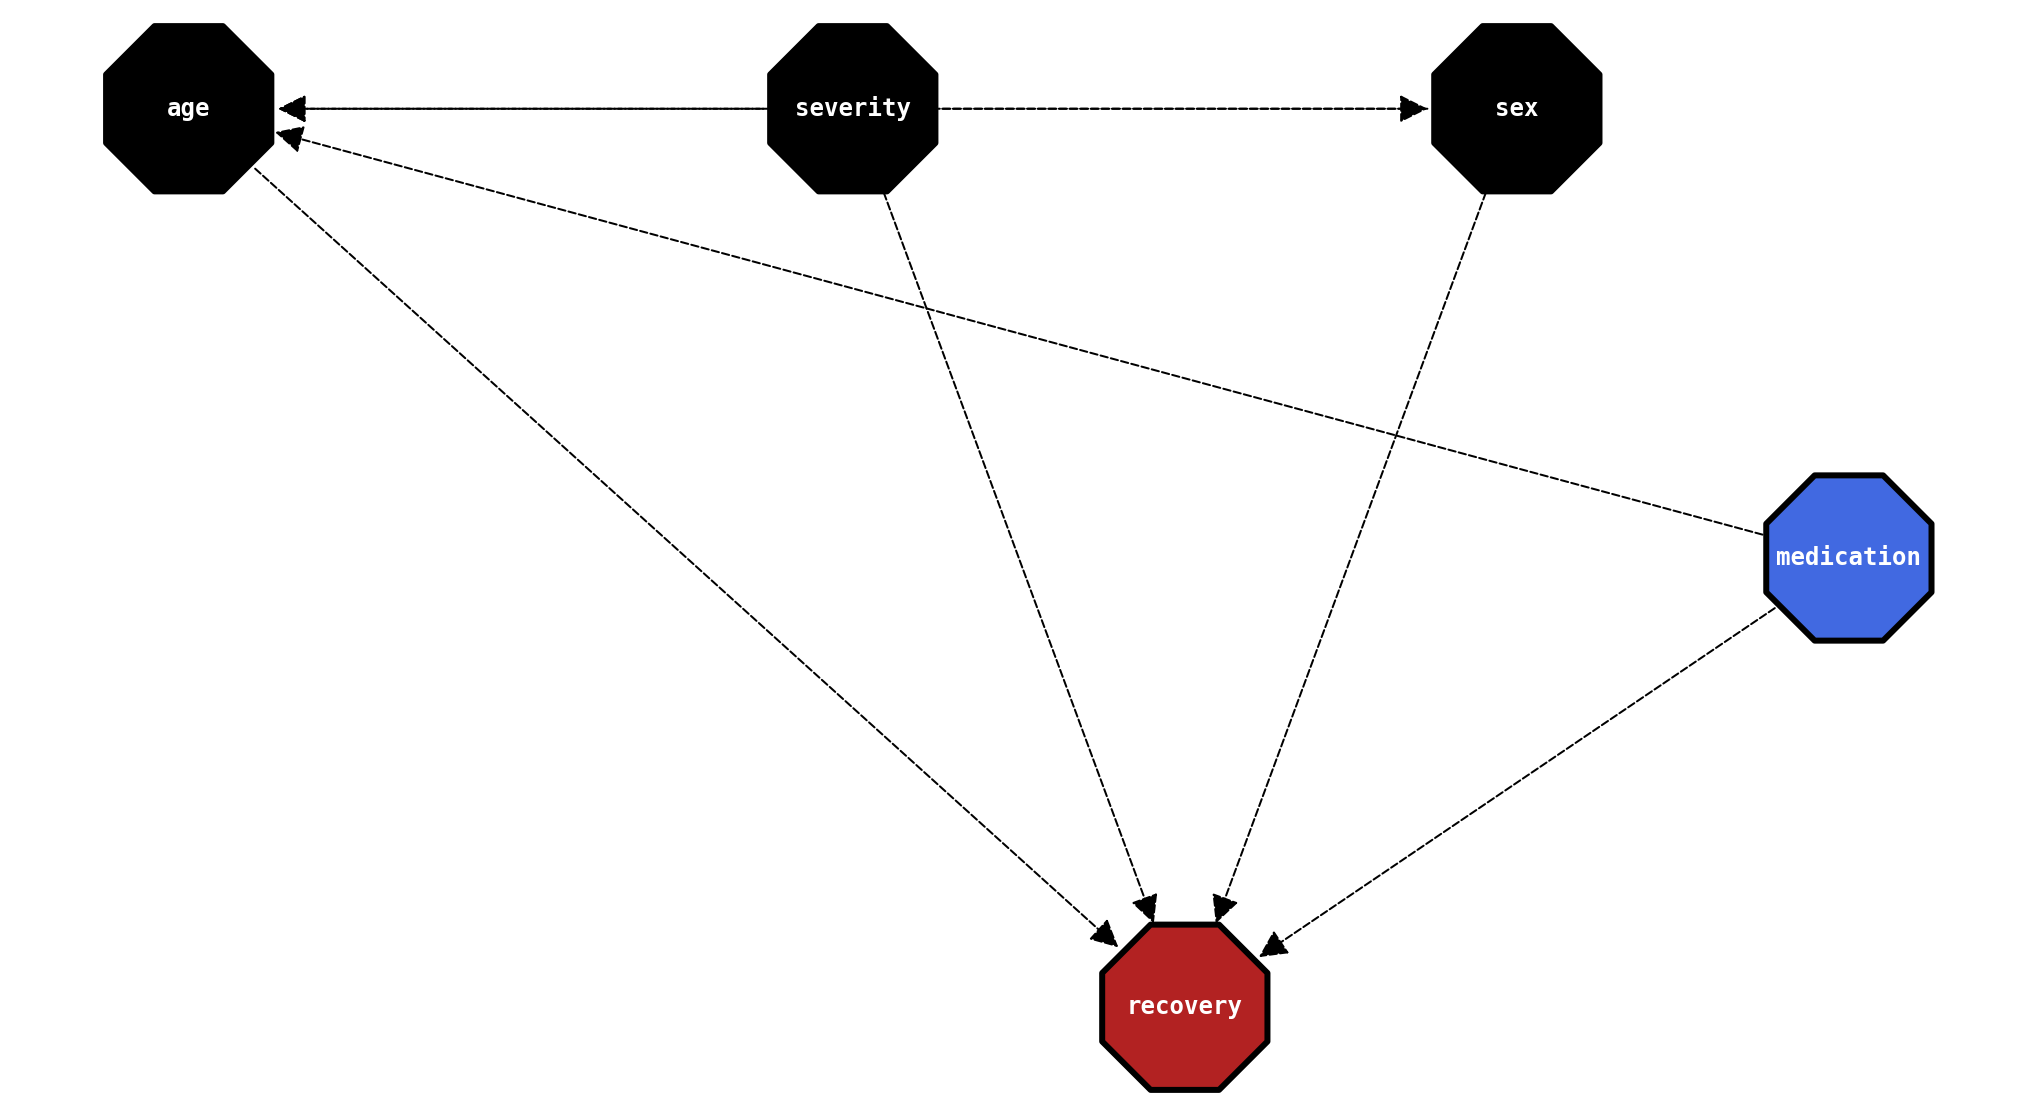

In [8]:
from causalnex.structure.notears import from_pandas

sm_learned = from_pandas(df_rnd)
sm_learned.remove_edges_below_threshold(0.5)

plot_structure(sm_learned)

Not bad, as the algorithm found that recovery depends on all variables. However, other edges seem awkward, specially `medication` being a cause of `age`. Nevertheless, structure leanring is recognized to be a very hard problem, and in most cases a domain expert will step in and make corrections to the relationships. It is a potentially very useful **feature** for exploring the data.

For the sake of fun and benchmarking, we'll store this structure so we can test it down the road.

### Naive structure

Another way to try to define structure is to use the design pattern of `X` (features), `W` (treatment) and `y` (target). An example is the [Genearlized Random Forest](https://github.com/grf-labs/grf) method by Athey et. al. We assume the causal graph where `X -> W -> y` and `X -> y`. Each feature is assumed to be a potential cause of the target variable and the treatment variable as well.

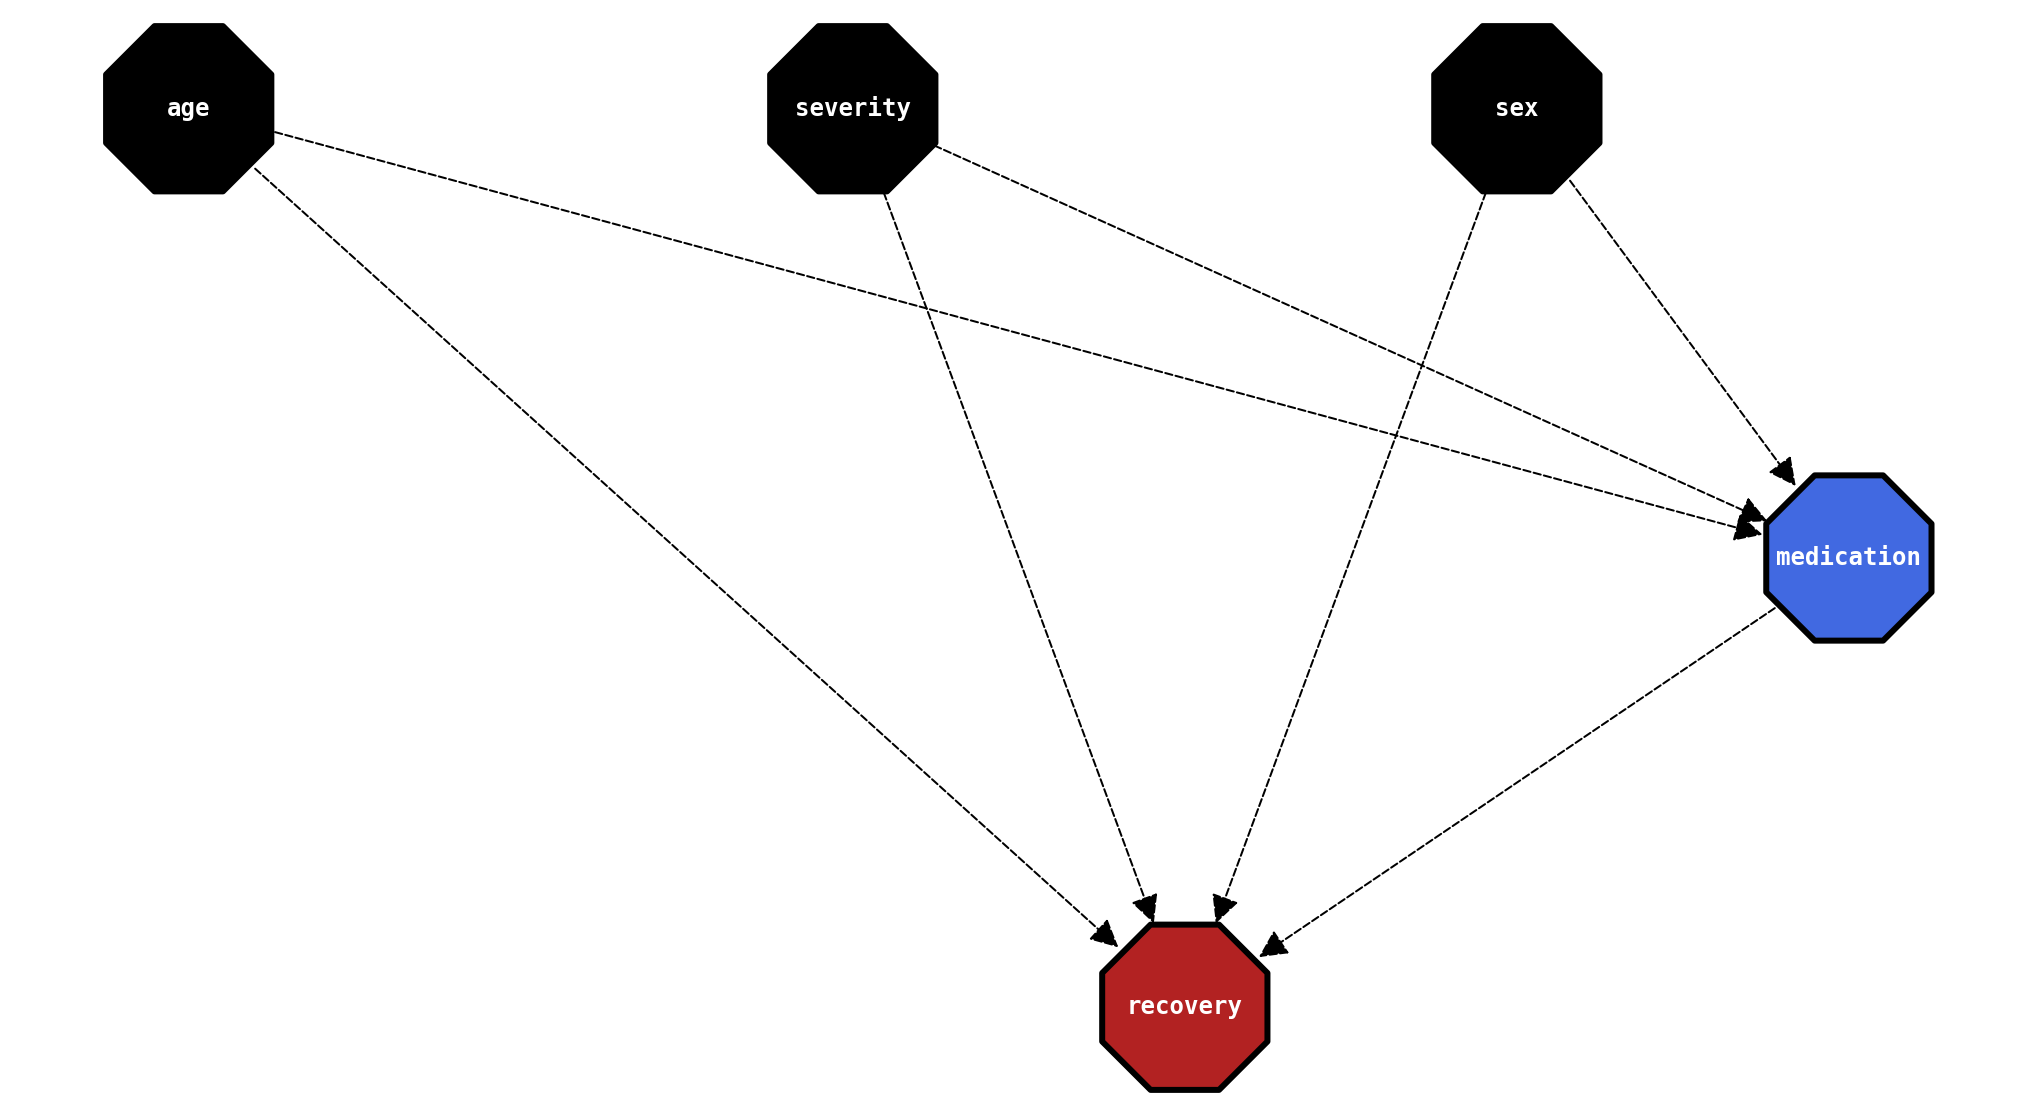

In [9]:
from causalnex.structure import StructureModel
sm_naive = StructureModel()

sm_naive.add_edges_from([
    ('medication', 'recovery'),
    ('sex', 'recovery'),
    ('age', 'recovery'),
    ('severity', 'recovery'),
    ('sex', 'medication'),
    ('age', 'medication'),
    ('severity', 'medication'),
])

plot_structure(sm_naive)

Cool. We're off to a good start. We have three structures to test and perform inference on. Moving on to step (2)!

## 2. Inference

We divide Inference in three substeps:

* Dataprep: we need to discretize our data so the Bayesian Network can perform computations. How we perform discretization makes a lot of difference, as we'll see further

* Fit and evaluation: we fit the network to data (which amounts to computing tables of probabilities) and evaluate it on a test set

* Counterfactuals: we use the network to perform queries and predictions and use them to compute counterfactuals

We will walk through a single run with the true causal structure. Then, we'll devise a procedure to test other structures and hyperparameters. Finally, we'll analyze results.

### Dataprep

Bayesian Networks in general require that we discretize variables prior to fitting them to data. This can either be a shortcomig or a feature: it may make results more interpretable by business stakeholders. However, it introduces an arbritrary choice that has a high impact on results that may hard to rationalize. Personally, I think the scale is tipped to this being a **shortcoming**, as I think the interpretability gains do not outweigh the introduction of a arbitrary choice.

For simplicity, we perforrm quantile-based discretization, where all the features are discretized to `n_bins` bins. We also perform transform binary variables into strings, log1p-transform the target variable, and split data into `train` and `test` sets.

We perform special treatment on the target variable such as the the discretized labels represent the expected value of the bins, so we preserve expected values and can correctly compute treatment effects further on. 

We start on the "easy mode" with `df_rnd`, where we do not have confounding.

In [10]:
import numpy as np
import pandas as pd

def discretize(df, n_bins=8):
    
    target = df['recovery']
    continuous = df[['age', 'severity']]
    binary = df[['medication', 'sex']]
    
    target = (
        target
        .to_frame()
        .assign(recovery_bin = lambda x: pd.qcut(x['recovery'], n_bins, duplicates='drop'))
        .groupby('recovery_bin').transform(lambda x: x.mean())
        .apply(np.log1p)
    
    )
    
    continuous = (
        continuous
        .apply(lambda x: pd.qcut(x, n_bins, duplicates='drop'))
        .apply(lambda x: [e.mid for e in x])
    )
    
    binary = binary.astype(int)
    binary['sex'] = binary['sex'].replace({1:'female', 0:'male'})
    binary['medication'] = binary['medication'].replace({1:'yes', 0:'no'})
    
    return pd.concat([continuous, binary, target], axis=1)

df_disc = discretize(df_rnd)

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_disc, train_size=0.8, random_state=42)

### Fitting and evaluating the Bayesian Network

We then proceed to fit a Bayesian Network to our processed data. `.fit_node_states(...)` acts like a dictionary / schema, saving the possible states of the network. Then, `.fit_cpds(...)` computes conditional probabilities. Now we transformed our structure into a generative model that can answer probabilistic queries.

In [12]:
from causalnex.network import BayesianNetwork

bn_true = BayesianNetwork(sm_true)

bn_true = bn_true.fit_node_states(df_disc)
bn_true = bn_true.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

The first query we do is to run our test  set thorugh the net and see if it can recover the true states of the target variable. This is actually a multi-class classification problem as we discretized our variables, so we use the micro-average ROC AUC.

In [13]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn_true, test, "recovery")
print(auc)

0.9284841721428572


This is actually a high AUC! The network did a good job computing de conditional probability distributions of the data. For instance, we can check that the probability of taking medication remains constant after conditioning on `severity` and `sex`, which is expected as we're using `df_rnd`. That kind of interpretability is clearly a **feature**.

In [14]:
bn_true.cpds['medication']

severity    0.046511           0.149000            0.268500            \
sex           female      male   female      male    female      male   
medication                                                              
no          0.496022  0.493538  0.49032  0.494447  0.503147  0.513121   
yes         0.503978  0.506462  0.50968  0.505553  0.496853  0.486879   

severity    0.399000            0.529500            0.654000            \
sex           female      male    female      male    female      male   
medication                                                               
no          0.500408  0.487431  0.487419  0.499805  0.498811  0.473748   
yes         0.499592  0.512569  0.512581  0.500195  0.501189  0.526252   

severity    0.774000            0.917000            
sex           female      male    female      male  
medication                                          
no          0.495596  0.496803  0.495851  0.497617  
yes         0.504404  0.503197  0.504149  0.502383

Let us now move to computing counterfactuals!

### Computing counterfactuals

As the network can act as a generative model, we can compute probabilistic queries on it. Furthermore, being a structural causal model, the net can also perform do-calulus $P(y \vert do(X))$ and compute counterfactuals. Specifically, we're interested in

$$T = \frac{P(recovery \vert do(medication = 1))}{P(recovery \vert do(medication = 0))}$$

where the expected value of $T$ is $exp(-1) = 0.368$. 

We start by using the `InferenceEngine` class, which exposes the `.do_intervention(...)` method, allowing us to perform do calculus. The following function returns the distribution of `recovery` given no treatment (`0`) and treatment (`1`). It is fairly easy and elegant to use and a good **feature** to have.

In [15]:
from causalnex.inference import InferenceEngine

def compute_medication_cf(bn):

    ie = InferenceEngine(bn)

    ie.do_intervention("medication", {'yes': 0.0, 'no': 1.0})
    recovery_no = pd.Series(ie.query()["recovery"])

    ie.do_intervention("medication", {'yes': 1.0, 'no': 0.0})
    recovery_yes = pd.Series(ie.query()["recovery"])

    cf = pd.concat([recovery_no, recovery_yes], axis=1)
    cf.index = np.expm1(cf.index)
    
    return cf

counterfactuals = compute_medication_cf(bn_true)
counterfactuals

,0,1
6.370508,0.014719,0.287532
11.475160,0.043949,0.174151
15.976869,0.089432,0.158214
21.386646,0.124811,0.137237
27.830198,0.129131,0.107342
36.427852,0.157128,0.082580
51.651627,0.198192,0.040695
92.038387,0.242637,0.012248


We can plot the distribution to check how the `medication` impacts `recovery`:

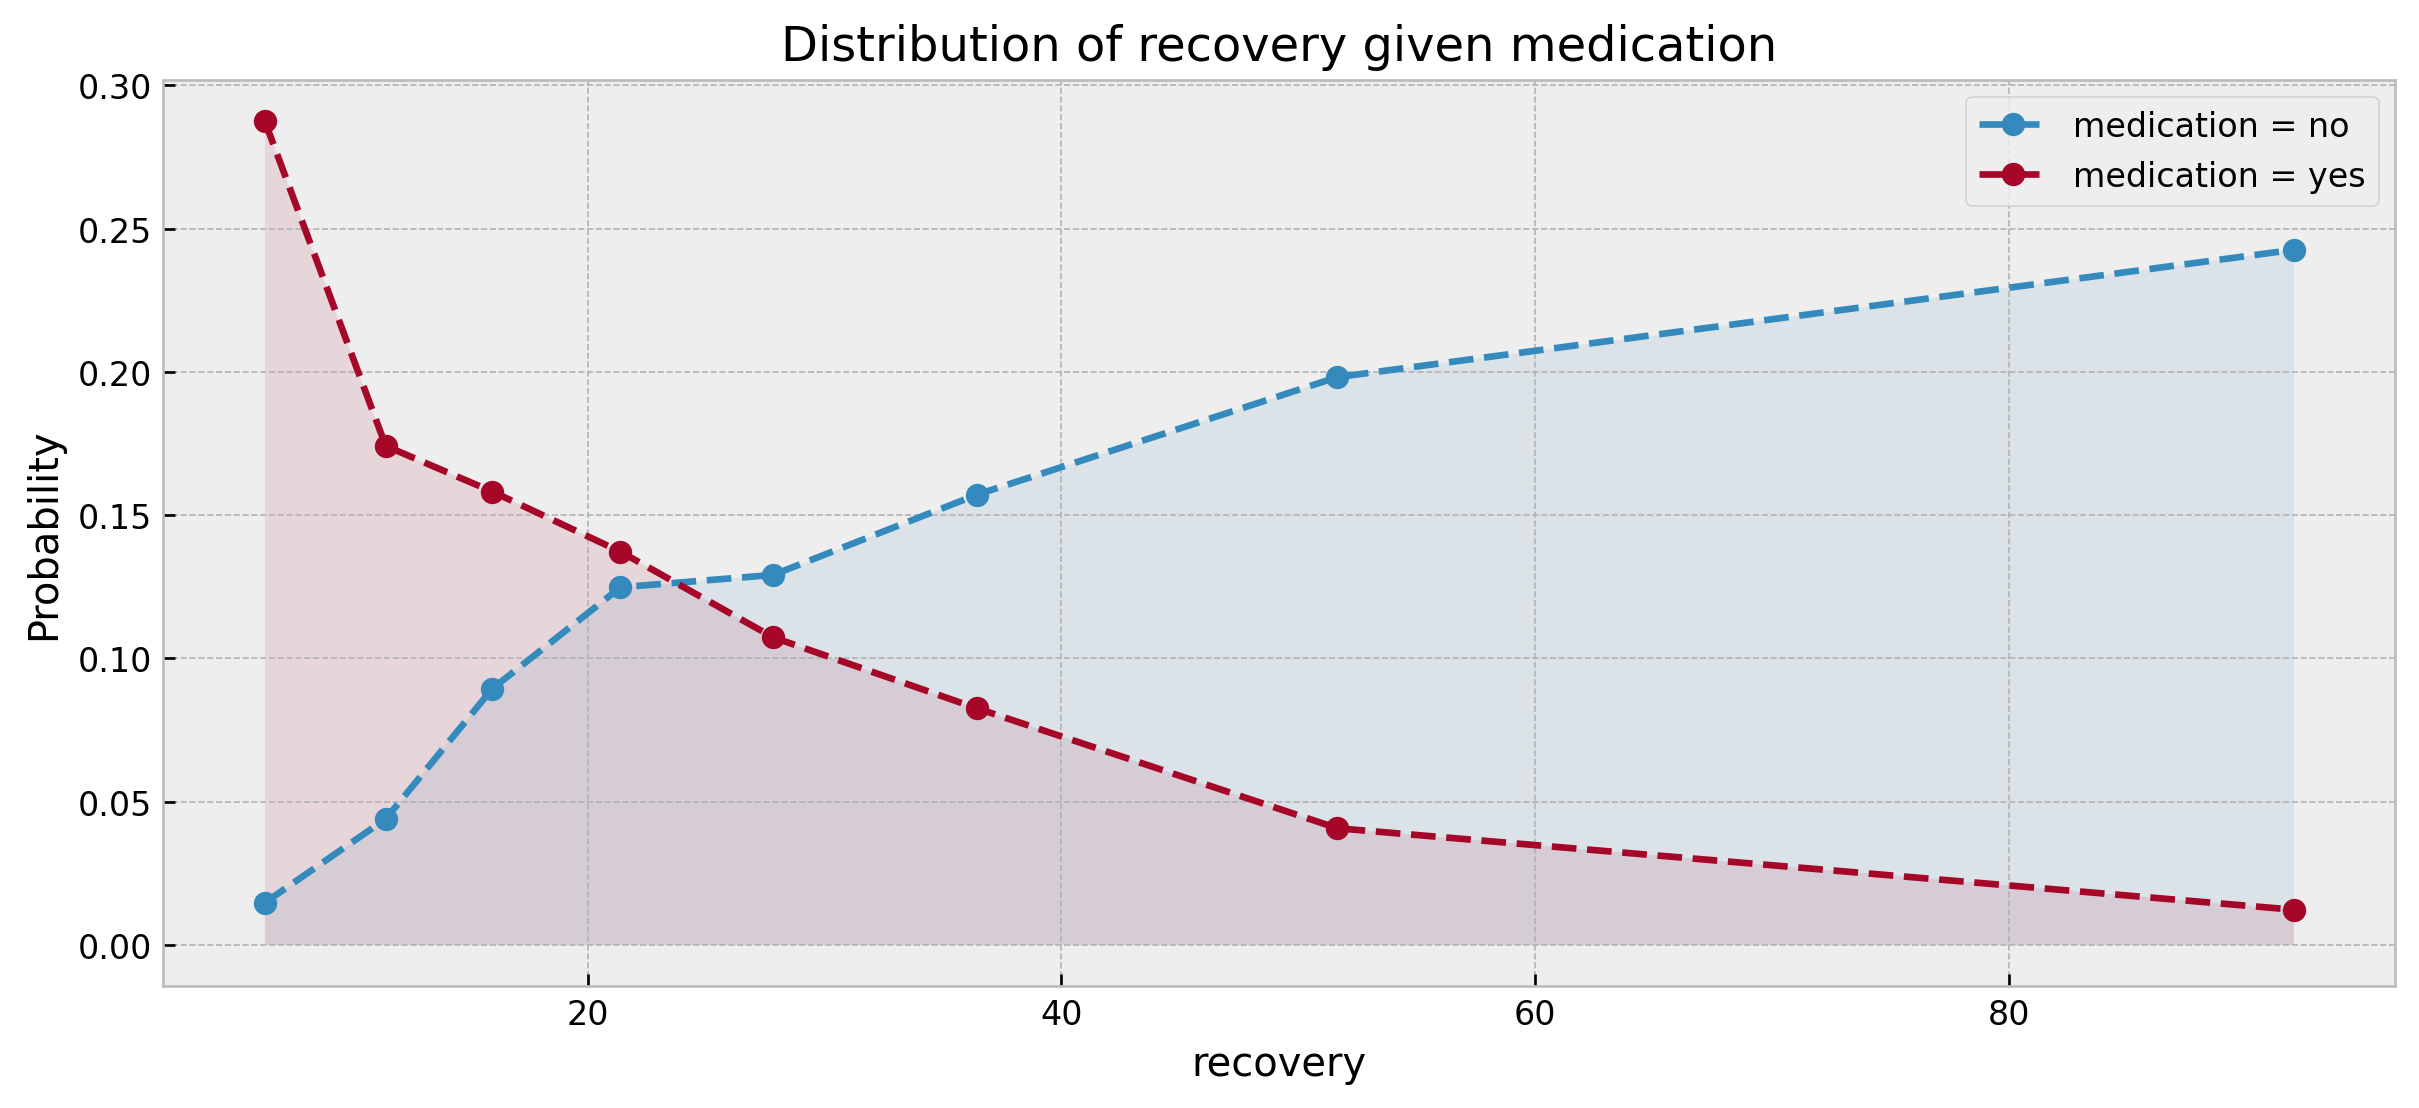

In [16]:
def plot_counterfactuals(cf):

    plt.figure(figsize=(12, 5), dpi=120)

    plt.plot(cf.index, cf[0], 'o--', label='medication = no')
    plt.fill_between(cf.index, cf[0], alpha=0.1)

    plt.plot(cf.index, cf[1], 'o--', label='medication = yes')
    plt.fill_between(cf.index, cf[1], alpha=0.1)

    plt.legend()
    plt.title('Distribution of recovery given medication')
    plt.xlabel('recovery');
    plt.ylabel('Probability');
    
plot_counterfactuals(counterfactuals)

We can clearly see that the distribution of recovery times for `medication = yes` is fairly skewed to the left as compared to `medication = no`, which shows an opposite pattern, indicating that medication provides an improvement. 

Then, we compute the effects by calculating the expected `recovery` value given treatment and no treatment. This is easy as we're assured that `recovery` labels reflect the bins expected values and we're with a multinomial distribution.

In [17]:
def compute_effect(cf):

    expected_no = (cf.index * cf[0]).sum()
    expected_yes = (cf.index * cf[1]).sum()
    
    effect = expected_yes/expected_no
    
    return effect

effect = compute_effect(counterfactuals)
print(f'The effect computed is {effect:.4f} / {np.log(effect):.2f} (log)')

The effect computed is 0.3975 / -0.92 (log)


And we're off to a reasonable start! The net recovered an effect of `0.3975` or `-0.92` in log space, which is close to the expected `0.368` and `-1` true values. The ease of use and the fact that the net recovered the true effect counts as a **feature**. 

However, there's an important **shortcoming**: the net does not provide confidence intervals, which implies that we will not have them as well for the final counterfactual. A Boostrap procedure could solve this, but it comes with the additional caveat of repeating the computationally expensive processes of training and executing do-calculus for several nets.

### Impact of confounding

Let us now try to solve `df_obs`, which has a high degree of confounding. For simplicity, let us abstract all steps into the `run_full_bayes_net_test` function:

In [18]:
def run_full_bayes_net_test(df, structure, n_bins, verbose=1):
        
    ## preparing data ##
    
    df_disc = discretize(df, n_bins)
    train, test = train_test_split(df_disc, train_size=0.8, random_state=42)
    
    ## setting up network and inference engine ##
    
    bn = BayesianNetwork(structure)
    
    ## fitting and evaluating network ##
    
    bn = bn.fit_node_states(df_disc)
    bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")
    
    roc, auc = roc_auc(bn, test, "recovery")
    
    ## running counterfactuals via inference engine ##
    
    counterfactuals = compute_medication_cf(bn)
    effect = compute_effect(counterfactuals)
    
    if verbose > 0:
        plot_counterfactuals(counterfactuals)
        print(f'The effect computed is {effect:.4f} / {np.log(effect):.2f} (log)')    
    
    return {
        'auc': auc,
        'effect': effect,
    }

Now we can run our test with any dataframe, structure and number of bins. Let us check out what happens if we run the net just like before but using the confounded `df_obs` dataset:

The effect computed is 0.7656 / -0.27 (log)


{'auc': 0.842287445, 'effect': 0.7656343570245092}

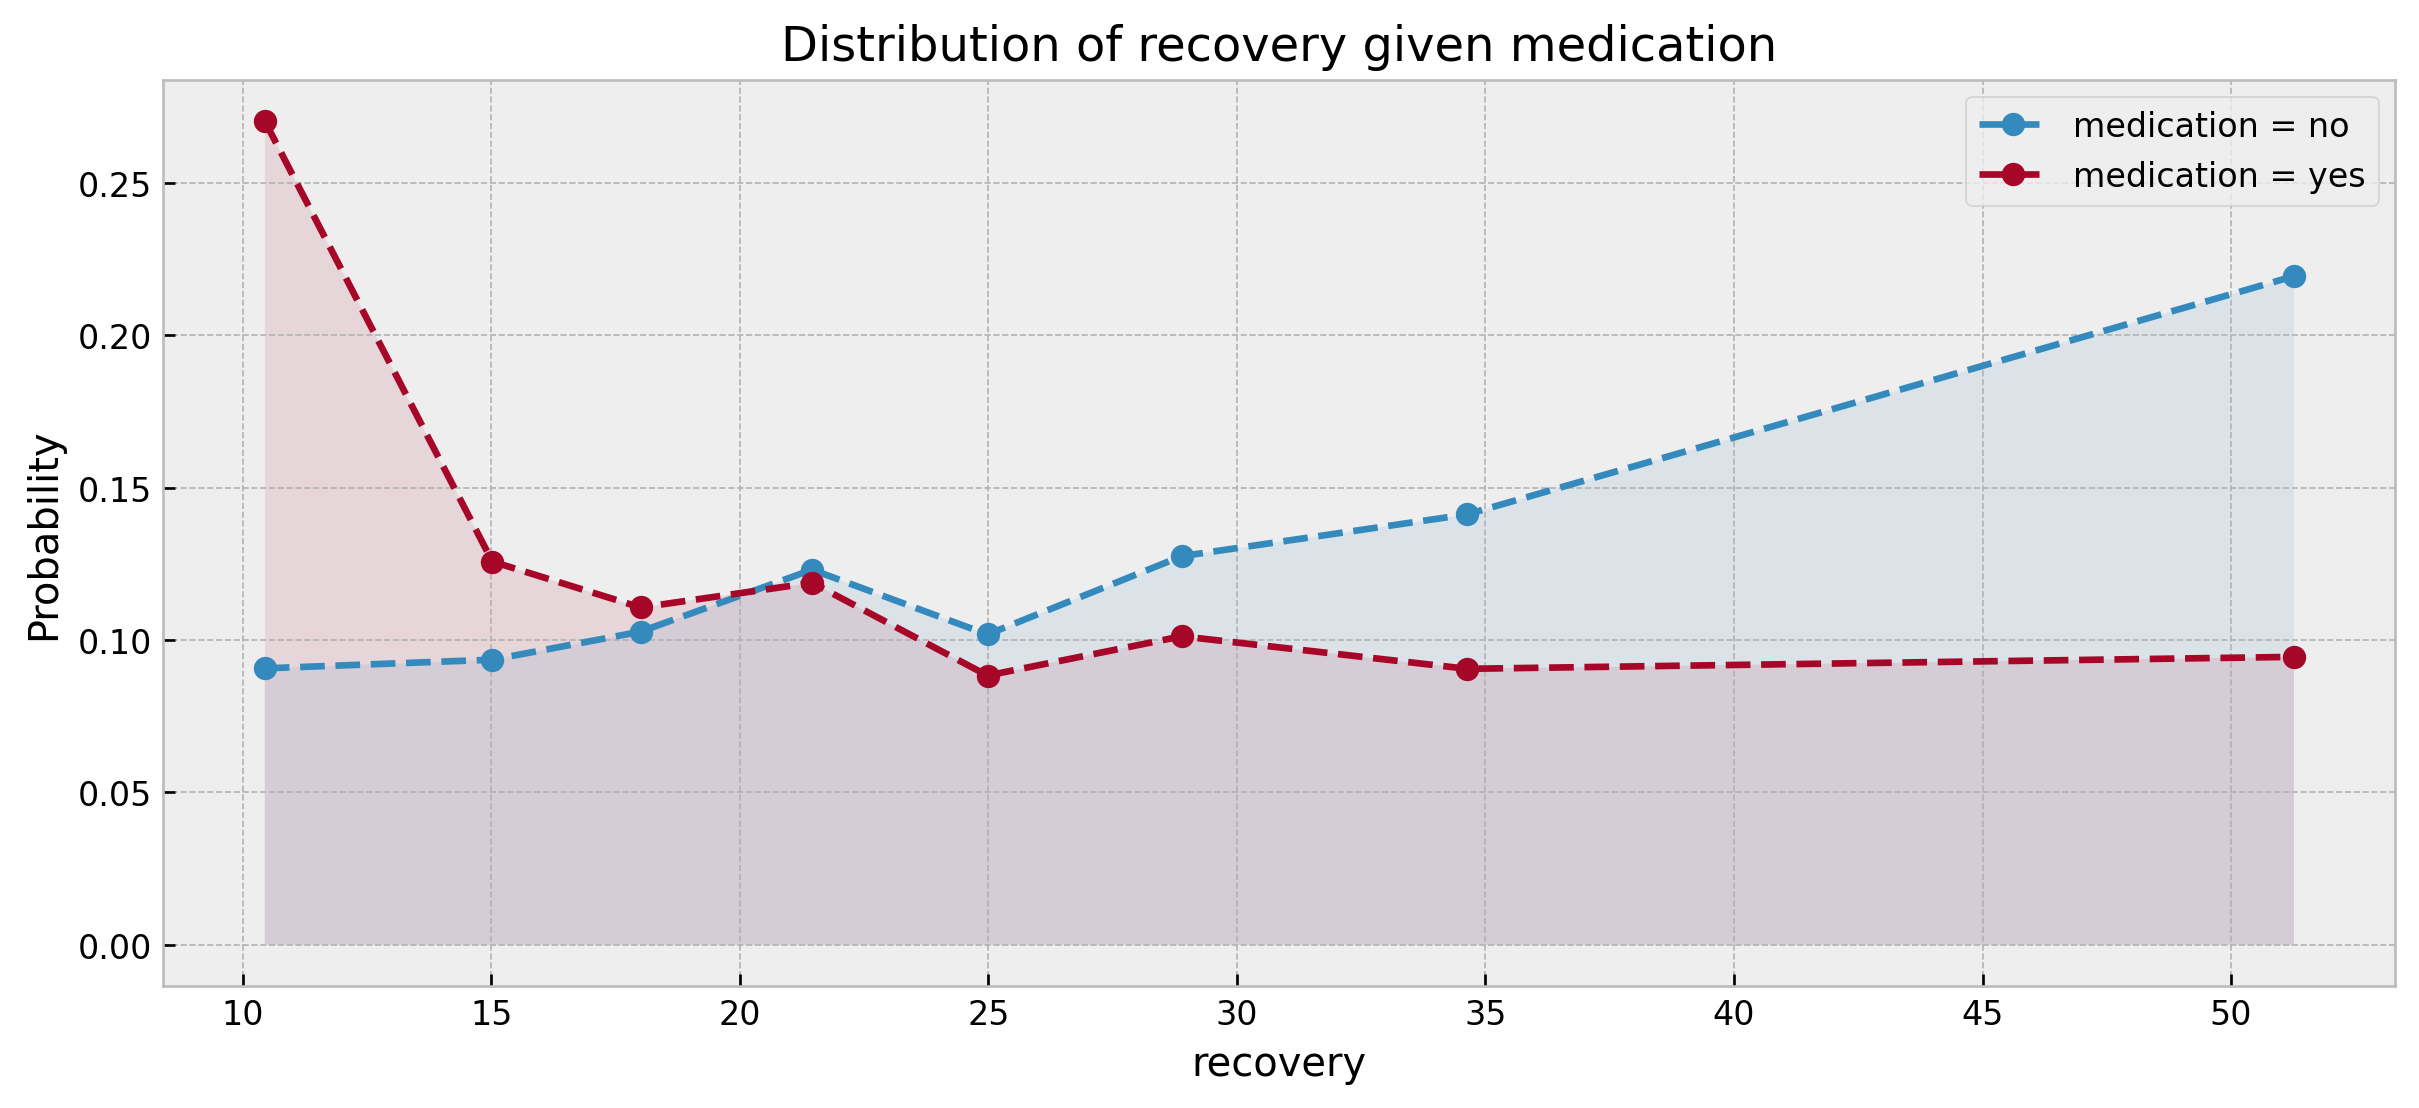

In [19]:
run_full_bayes_net_test(df_obs, sm_true, 8)

Actually, in this case, confounding damaged the counterfactual estimate of the network, which underestimated the effect by a large margin (`0.7656 ` vs. `0.368`/ `-0.27` vs. `-1.0`), despite still getting the direction right (medication improves recovery). What did go wrong? I actually expected that the Bayesian Network would perform well on the confounded case, and would count this as a major **shortcoming**. 

Let us move to test how different hyperparmeters impact the performance of the Bayesian Network. Particularly, we'll examime `n_bins` and `structure`, for both confounded and unconfouded datasets.

### Impact of hyperparameters and confounding

To test different hyperparamters the code below performs a grid search where we try `n_bins` in `[2, 4, 8, 16, 32]`, `structure` in `[sm_true, sm_learned, sm_naive]` and `df` in `[df_obs, df_rnd]`. 

In [ ]:
import itertools

result_list = []

grid_bins = [2, 4, 8, 16, 32]
grid_df = [('df_obs', df_obs), ('df_rnd', df_rnd)]
grid_structure = [('true', sm_true), ('learned', sm_learned), ('naive', sm_naive)]

for n_bins, df, structure in itertools.product(grid_bins, grid_df, grid_structure):
    
    result = run_full_bayes_net_test(df[1], structure[1], n_bins, verbose=0)
    
    result['n_bins'] = n_bins
    result['dataset'] = df[0]
    result['structure'] = structure[0]
    
    result_list.append(result)
    print(result)

{'auc': 0.8538667799999999, 'effect': 0.7010060092331797, 'n_bins': 2, 'dataset': 'df_obs', 'structure': 'true'}
{'auc': 0.8538667799999999, 'effect': 0.7256966277468403, 'n_bins': 2, 'dataset': 'df_obs', 'structure': 'learned'}
{'auc': 0.8538667799999999, 'effect': 0.6584995294901578, 'n_bins': 2, 'dataset': 'df_obs', 'structure': 'naive'}
{'auc': 0.94833506, 'effect': 0.531016682332377, 'n_bins': 2, 'dataset': 'df_rnd', 'structure': 'true'}
{'auc': 0.94833506, 'effect': 0.5283773862827291, 'n_bins': 2, 'dataset': 'df_rnd', 'structure': 'learned'}
{'auc': 0.94833506, 'effect': 0.4706010855133055, 'n_bins': 2, 'dataset': 'df_rnd', 'structure': 'naive'}
{'auc': 0.8503423349999999, 'effect': 0.6849761070092604, 'n_bins': 4, 'dataset': 'df_obs', 'structure': 'true'}
{'auc': 0.8503423349999999, 'effect': 0.6931581430020562, 'n_bins': 4, 'dataset': 'df_obs', 'structure': 'learned'}
{'auc': 0.8503423349999999, 'effect': 0.6396424862976995, 'n_bins': 4, 'dataset': 'df_obs', 'structure': 'naiv

Then, we plot the results below:

In [ ]:
def plot_results(result_list):
    
    results_df = pd.DataFrame(result_list)
    results_df['effect'] = np.log(results_df['effect'])
    
    results_rnd = results_df.query("""dataset == 'df_rnd'""")
    results_obs = results_df.query("""dataset == 'df_obs'""")

    plt.figure(figsize=(16, 10), dpi=150)

    plt.subplot(2, 2, 1)
    plt.axhline(-1.0, color='black', linestyle='dashed', label='true effect')
    for sm, grp in results_rnd.groupby('structure'):
        plt.plot(grp['n_bins'], grp['effect'], 'o--', label=sm)

    plt.title('Effect recovered (uncounfounded dataset)')
    plt.xlabel('Number of bins')
    plt.ylabel('Effect')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.axhline(-1.0, color='black', linestyle='dashed', label='true effect')
    for sm, grp in results_obs.groupby('structure'):
        plt.plot(grp['n_bins'], grp['effect'], 'o--', label=sm)

    plt.title('Effect recovered (counfounded dataset)')
    plt.xlabel('Number of bins')
    plt.ylabel('Effect')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    for sm, grp in results_rnd.groupby('structure'):
        plt.plot(grp['n_bins'], grp['auc'], 'o--', label=sm)

    plt.title('Area under the curve (uncounfounded dataset)')
    plt.xlabel('Number of bins')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(2, 2, 4)
    for sm, grp in results_obs.groupby('structure'):
        plt.plot(grp['n_bins'], grp['auc'], 'o--', label=sm)

    plt.title('Area under the curve (counfounded dataset)')
    plt.xlabel('Number of bins')
    plt.ylabel('AUC')
    plt.legend()


plot_results(result_list)

The plots show a interesting pattern. The true effect is shown by the black dashed line at `y = -1.0`. In the uncounfounded case, our counterfactual estimation procedure got really close to the true effect using a "modest" number of bins (4 and 8). The best structure was surprisingly the naive structure, although not by a large margin. The learned structure and the true structure arrived at almost identical results, which is also puzzling. 

However, we see another major **shortcoming** of Bayesian Networks (at least in this setting): if the number of bins is too high or too low, we greatly underestimate the treatment effect. In a real-world setting, where we would not know the true effect, tuning this parameter would be challenging. Moreover, I would find very hard to trust the treatment effect estimate knowing of this sensibility to hyperparameters.

In the confounded case we observe the same pattern as we did before, with our Bayesian Network approach underestimating the effect across the board, independently of structure or discretization choice.

AUC results are the same independent of structure, which is puzzling as well (maybe there's a bug on my code?).

Let us now summarize all that we've learned and list the main **features** and **shortcomings** of Bayesian Networks.

## Conclusion

In this post, we took CausalNex for a spin to try Bayesian Networks out, a promising idea for causal inference. We used a synthetic causal inference dataset to allow us to compare the model results to ground truth in an objective way. From this exploration we could check the main **features** and **shortcomings** of the approach. I list them below.

##### *Features* 

* **Building the DAG:** having a interface for a structural causal model incentivizes the practitioner to *think hard* about the problem and invites contribution from everyone (not just data scientists). We can also blend data with domain knowledge.

* **Structure learning:** even if we did not recover the true structure exactly, the structure learning functionaly did a decent job and could be a valuable tool for exploring a new dataset.

* **Inspecting conditional probabilities:** Bayesian Networks go one step further when showing conditional probabilities tables of the data. I found that `.cpds` provides an overview of the relationships between variables in a much more powerful way than correlation analysis.

* **Do-calculus:** the do-calculus functionality is very easy to use and flexible. 

##### *Shortcomings* 

* **Discretization:** having the need of discretizing the data can also be a feature to make the dataset easier to reason about. However, as we've seen, the introduction of this arbitrary choice can have a great impact on counterfactual estimation.

* **No confidence intervals, and high computational cost:** our implementation of bayesian networks did not output confidence intervals, which are very useful to diagnose the accuracy of the estimated effects. One could argue that this can be solved with bootstrap, but the high computational cost of the bayesian network can make this solution unfeasible.

* **High hyperparameter sensivity:** small changes on hyperparameters greatly impact the treatment effect estimate from the net (specially the ones related to discretization).

* **Poor performrance on confounded data:** the implementation showed poor results on confounded data. 

And that's it! I hope it was a good read. All feedbacks are highly appreciated!